In [14]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import torch.nn as nn
import pydicom
import SimpleITK as sk
from pathlib import Path
from rt_utils import RTStructBuilder
import matplotlib.pyplot as plt

In [50]:
class DosePrdictionDataset(Dataset):
    def __init__(self,  
                 input_dir:list,
                 input_types:list,
                 transform=None, 
                ):
        self.transform = transform
        self.input_dir = input_dir
        self.input_types = input_types
        
    def __len__(self):
        return len(self.input_dir)
    
    def __getitem__(self, index:int):
        subfolder_dir = self.input_dir[index] # get folder path for one specific patient
        X, y = self.get_X_y(subfolder_dir) # create inputs and output for this patient
        return X,y
    
    ## FUNCTION TO CREATE INPUTS AND OUTPUT
    def get_X_y(self, patient_dir):      
        input_dir = []
        for root, dirs, files in os.walk(patient_dir):
            input_dir.append(root)  
            
        # ---- get paths for different inputs ----
        X_paths_CT = [input_path for input_path in input_dir if any(input_path == "CT" for input_type in self.input_types)]
        X_paths_STRUCT = [input_path for input_path in input_dir if any(input_path.endswith("STRUCT") for input_type in self.input_types)]
        y_paths = [input_path for input_path in input_dir if input_path.endswith("DOSE")]  
        
        # ---- get inputs ----
        if self.transform != None:
            # 1.get CT and Strcut
            ct = self.transform(self.extract_images(X_paths_CT[0])) # get CT scan
            X = self.transform(self.extract_struct(X_paths_CT, X_paths_STRUCT, [type for type in self.input_type if type!="CT" and type!="DOSE"]).append(ct)) # get struct contours
            X = torch.from_numpy(np.stack(X).astype("int32")).type(torch.float32) # convert to tensor
        else:
            # 1.get CT and Strcut
            ct = self.extract_images(X_paths_CT[0]) # get CT scan
            X = self.extract_struct(X_paths_CT, X_paths_STRUCT, [type for type in self.input_type if type!="CT" and type!="DOSE"]).append(ct) # get struct contours
            X = torch.from_numpy(np.stack(X).astype("int32")).type(torch.float32) # convert to tensor
            
        # ---- get Dose map ----
        y_path = [path for path in X_paths if "DOSE" in path][0]
        y = np.array([self.extract_images(y_path)])         
        return X,y
    
    ## FUNCTION TO EXTRACT CT AND DOSE IMAGES
    def extract_images(self, folder_path):
        subfolder_dirs = []
        for roots, dirs, files in os.walk(folder_path):
            subfolder_dirs.append(roots)
        subfolder_path = subfolder_dirs[1]
        subfolder_path = Path(subfolder_path)
        file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(subfolder_path))
        file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(subfolder_path), file_ids[0])
        series_reader = sk.ImageSeriesReader()
        series_reader.SetFileNames(file_names)
        image_data = series_reader.Execute()
        images_3D = sk.GetArrayFromImage(image_data)
        if "DOSE" in folder_path:
            return images_3D[0]
        return images_3D
    
    ## FUNCTION TO CTEATE STRUCTURE CONTOURS
    def extract_struct(self, CT_folder_path:str, strcut_folder_path:str, struct_name:list):
        rtstruct = RTStructBuilder.create_from(dicom_series_path=CT_folder_path, 
                                               rt_struct_path=strcut_folder_path)
        masks = []
        for struct in struct_name:
            mask = rtstruct.get_roi_mask_by_name(struct_name)
            mask = np.stack([mask[:,:,i] for i in range(mask.shape[2])])
            masks.append(mask)
        return masks
        
    ## FUNCTION TO CTOP IMAGES
    def crop_image(self):
        pass

In [137]:
folder_path = "/Users/wangyangwu/Documents/Maastro/NeuralNets/PROTON/P0439C0006I1473766/CT"
subfolder_dirs = []
for roots, dirs, files in os.walk(folder_path):
    subfolder_dirs.append(roots)
subfolder_path = subfolder_dirs[1]
subfolder_path = Path(subfolder_path)
file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(subfolder_path))
file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(subfolder_path), file_ids[0])
series_reader = sk.ImageSeriesReader()
series_reader.SetFileNames(file_names)
image_data = series_reader.Execute()
images_3D = sk.GetArrayFromImage(image_data)
if "DOSE" in folder_path:
    images_3D = images_3D[0]

In [138]:
images_3D = images_3D[10:100,:,:]

In [139]:
images_3D.shape

(90, 512, 512)

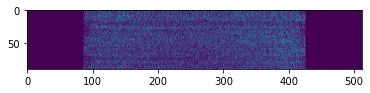

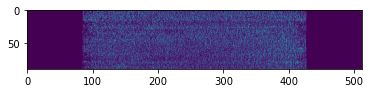

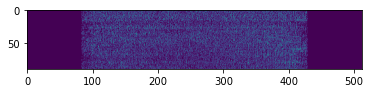

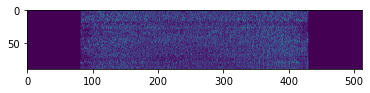

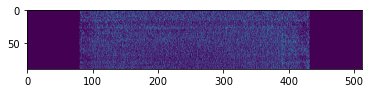

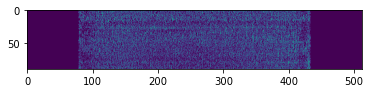

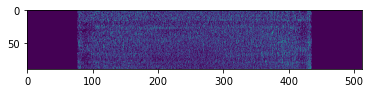

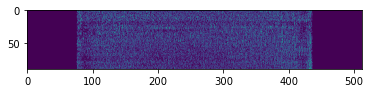

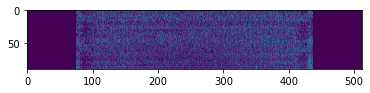

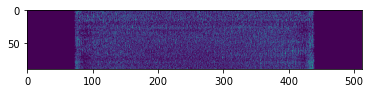

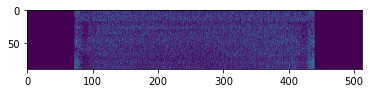

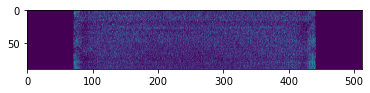

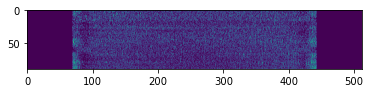

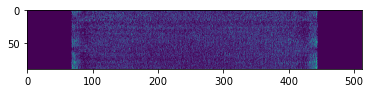

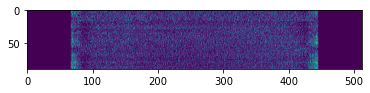

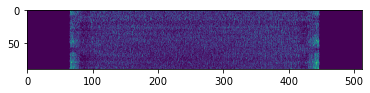

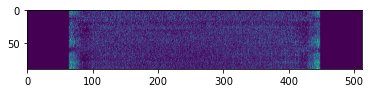

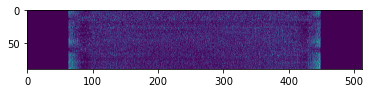

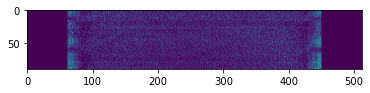

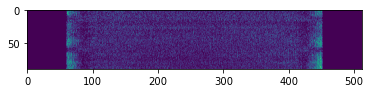

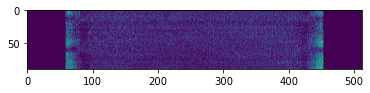

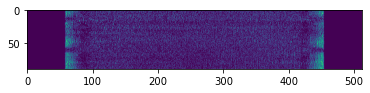

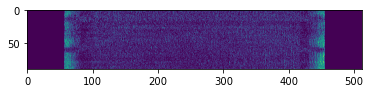

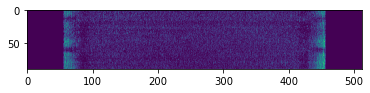

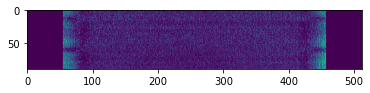

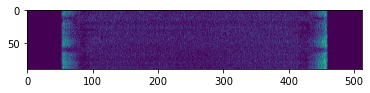

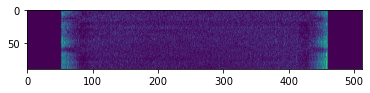

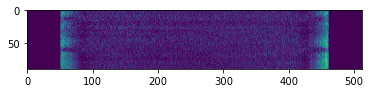

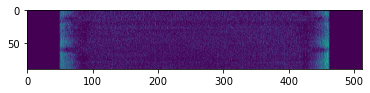

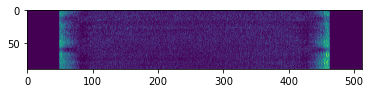

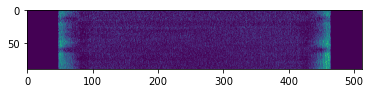

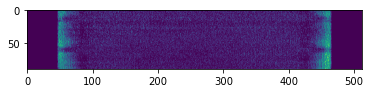

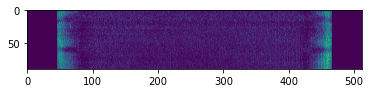

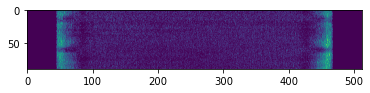

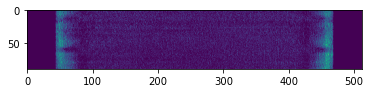

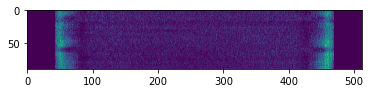

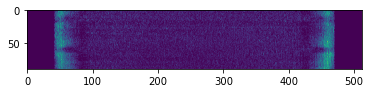

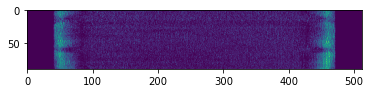

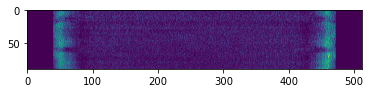

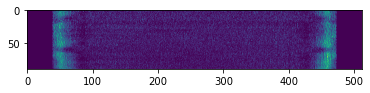

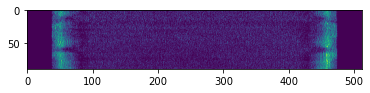

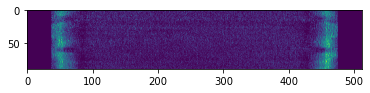

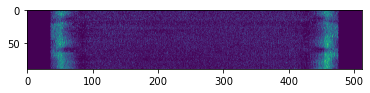

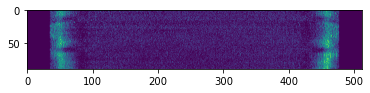

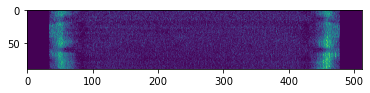

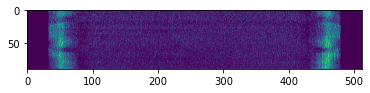

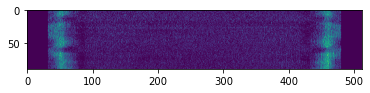

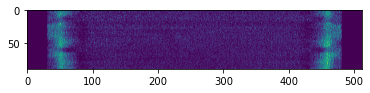

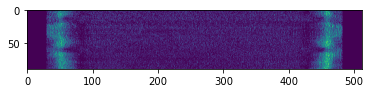

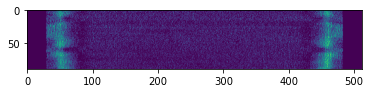

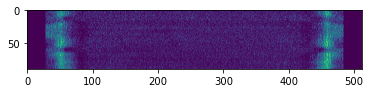

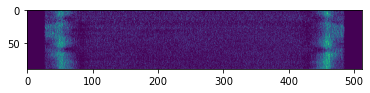

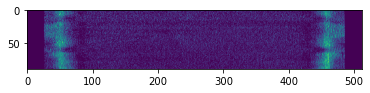

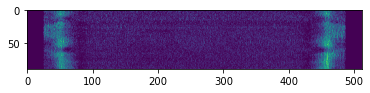

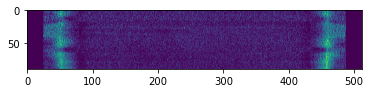

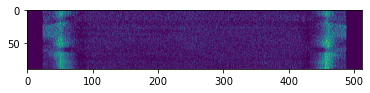

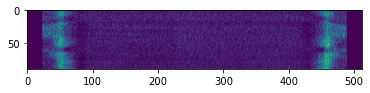

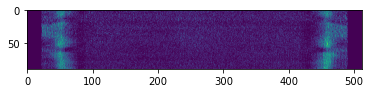

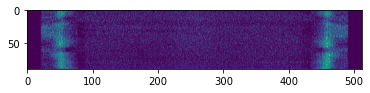

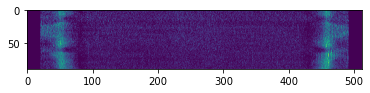

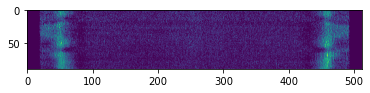

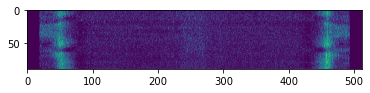

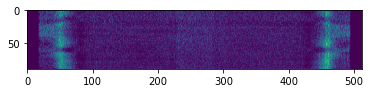

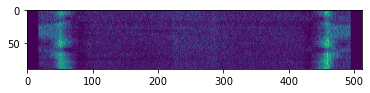

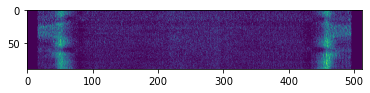

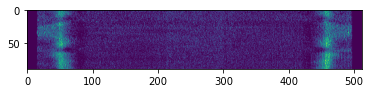

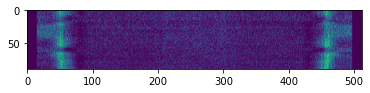

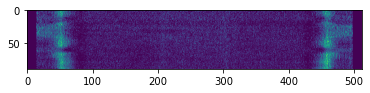

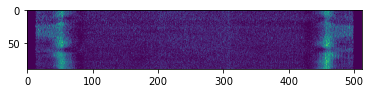

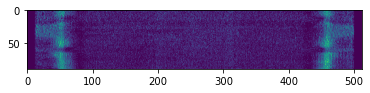

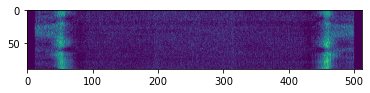

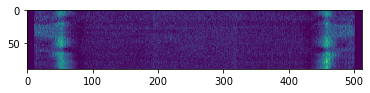

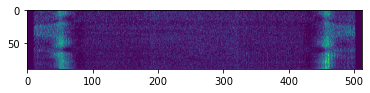

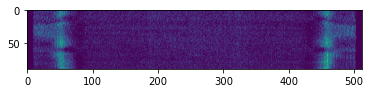

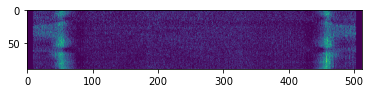

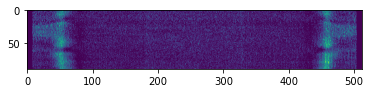

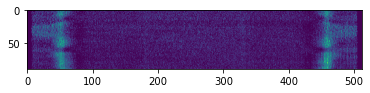

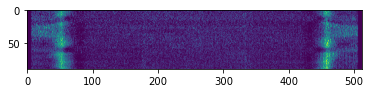

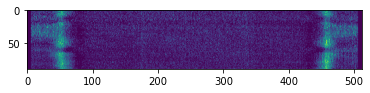

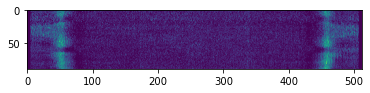

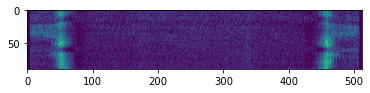

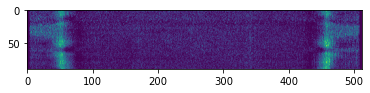

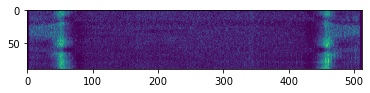

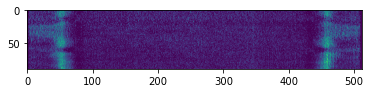

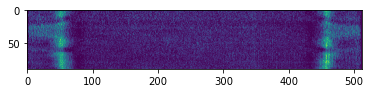

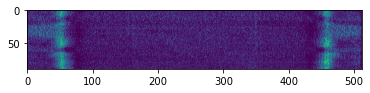

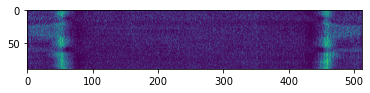

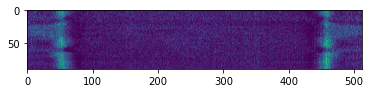

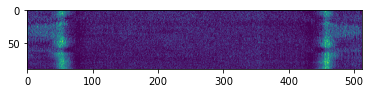

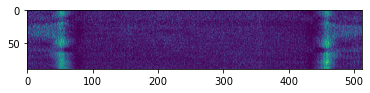

In [140]:
for i in range(90):
    plt.imshow(images_3D[:,i,:])
    plt.show()